# Creating MSTL residuals

In [30]:
library(forecast)
library(ggplot2)
library(dplyr)
library(data.table)
library(progress)
library(IRdisplay)

In [31]:
# Custom display function for the first and last 5 rows
display_limited <- function(dt) {
  # Concatenate the first 5 and last 5 rows
  limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}

In [32]:
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)

data <- fread(paste0(base_path,"/Output_file.csv"))
data <- data[,.(HourDK,GrossConsumptionMWh)]
data <- head(data, n=17544)

# Use the display_limited function
display_limited(data)

HourDK,GrossConsumptionMWh
2020-01-01 00:00:00,3331.34729
2020-01-01 01:00:00,3257.505005
2020-01-01 02:00:00,3161.865601
2020-01-01 03:00:00,3074.752442
2020-01-01 04:00:00,3009.696167
...,...
2021-12-31 19:00:00,4461.808715
2021-12-31 20:00:00,4226.844238
2021-12-31 21:00:00,4057.121583
2021-12-31 22:00:00,3875.883911


In [33]:
# Initialize an empty data frame to store metrics for all individuals
MSTL_results <- data.frame()
X_t <- data

# Creating multi time series (y_t)
Y_t <- data[,"GrossConsumptionMWh"]
Y_t_ts <- msts(Y_t, seasonal.periods = c(24, 24*7, 24*365))

  # Using MSTL to find residuals, R_t
mstl_decomp <- mstl(Y_t_ts, lambda = NULL, iterate = 10000, s.window = c(24, 24*7, 24*365))
mstl_decomp_DT <- as.data.table(mstl_decomp)
X_t$Trend        <- mstl_decomp_DT$Trend
X_t$Seasonal24   <- mstl_decomp_DT$Seasonal24
X_t$Seasonal168  <- mstl_decomp_DT$Seasonal168
X_t$Seasonal8760 <- mstl_decomp_DT$Seasonal8760
X_t$Remainder    <- mstl_decomp_DT$Remainder
mstl_decomp_DT <- as.data.table(X_t)

In [34]:
summary(mstl_decomp_DT[,.(Trend, Seasonal24, Seasonal168, Seasonal8760, Remainder)])

     Trend        Seasonal24          Seasonal168          Seasonal8760       
 Min.   :3878   Min.   :-1179.3220   Min.   :-1621.2541   Min.   :-1308.2370  
 1st Qu.:4003   1st Qu.: -460.7094   1st Qu.: -203.3037   1st Qu.: -374.2947  
 Median :4111   Median :  139.2097   Median :   14.0054   Median :  -55.9614  
 Mean   :4087   Mean   :   -0.0187   Mean   :    0.5509   Mean   :   -0.2827  
 3rd Qu.:4173   3rd Qu.:  431.4036   3rd Qu.:  382.8124   3rd Qu.:  357.1573  
 Max.   :4236   Max.   : 1229.4021   Max.   : 1179.5105   Max.   : 1674.3971  
   Remainder        
 Min.   :-1429.890  
 1st Qu.:  -81.980  
 Median :    1.001  
 Mean   :    2.688  
 3rd Qu.:   85.772  
 Max.   : 1399.439  

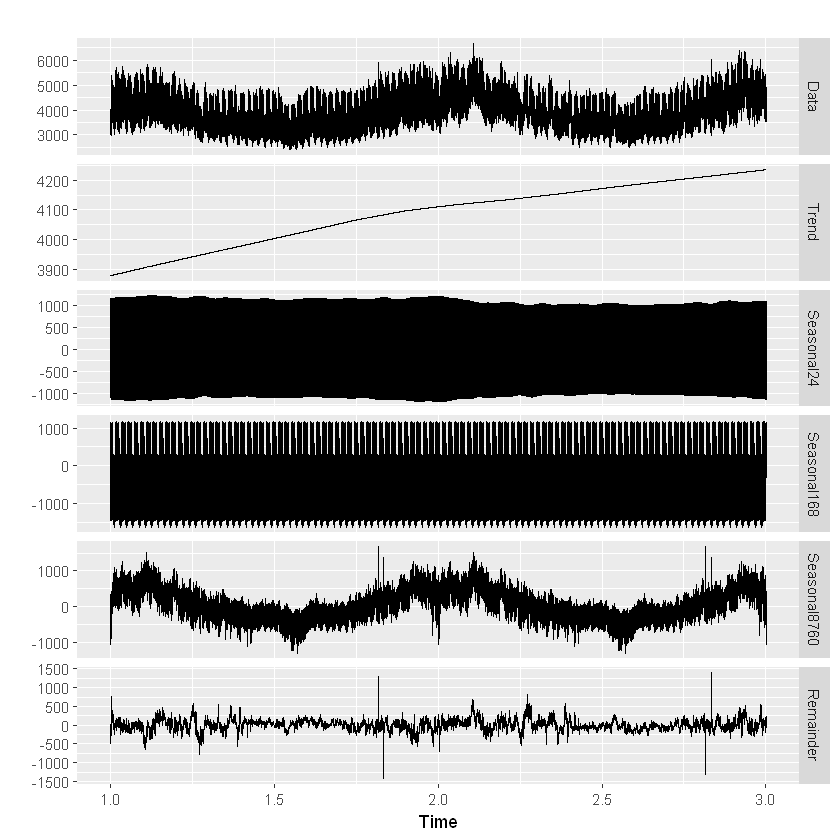

In [35]:
mstl_decomp %>% autoplot()

In [36]:
mstl_decomp_DT$Null_Remainder = 0

In [37]:
display_limited(mstl_decomp_DT)

HourDK,GrossConsumptionMWh,Trend,Seasonal24,Seasonal168,Seasonal8760,Remainder,Null_Remainder
2020-01-01 00:00:00,3331.34729,3877.51441012093,550.860179312665,-1131.01852047392,57.0736782751744,-23.0824572348588,0
2020-01-01 01:00:00,3257.505005,3877.54383660321,919.388593344611,-1454.71919179548,-91.5155377932393,6.80730464090084,0
2020-01-01 02:00:00,3161.865601,3877.5732630855,-287.515348314915,-669.209677209973,233.134045024667,7.88331841477748,0
2020-01-01 03:00:00,3074.752442,3877.60268956779,-1099.83632389649,-26.4632507438256,337.597057657652,-14.1477305851286,0
2020-01-01 04:00:00,3009.696167,3877.63211605008,-1026.35961862536,-0.195273325147246,230.486009510095,-71.8670666096618,0
...,...,...,...,...,...,...,...
2021-12-31 19:00:00,4461.808715,4236.41612104319,353.306116437067,-137.685514162477,-21.5595332112295,31.3315248934232,0
2021-12-31 20:00:00,4226.844238,4236.43085864455,187.849325707751,-295.335230449598,65.1370220633128,32.7622620338598,0
2021-12-31 21:00:00,4057.121583,4236.44559624591,-527.938934404538,34.6796518463759,238.410638930719,75.5246303815193,0
2021-12-31 22:00:00,3875.883911,4236.46033384727,-1123.61530137508,297.242977532792,428.541976246703,37.2539247483082,0


In [38]:
fwrite(mstl_decomp_DT, "MSTL_decomp_results_2year.csv")